<a href="https://colab.research.google.com/github/rifat01-rahman/Project-of-Python/blob/main/States_model_ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsforecast --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 6.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
from statsforecast import StatsForecast
import matplotlib.pyplot as plt

In [3]:
# Gas price data set
ts = pd.read_csv('/content/HHNGSP.csv')

In [4]:
ts.shape

(6931, 2)

In [5]:
ts.head()

,Date,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [6]:
df= ts.rename(columns={'Date':'DATE', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'price'})

In [7]:
df.head()

,DATE,price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [8]:
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')  # convert, invalid parsing -> NaT
    df = df.dropna(subset=['DATE'])  # drop invalid dates
    df_t = df.set_index('DATE').sort_index()
else:
    raise KeyError("Column 'DATE' not found in DataFrame")

In [9]:
df_t.head()

,price
DATE,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00


In [10]:
final_d = df_t[['price']].dropna()

In [11]:
final_d.isnull().sum()

,0
price,0


In [12]:
final_d.head()

,price
DATE,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00


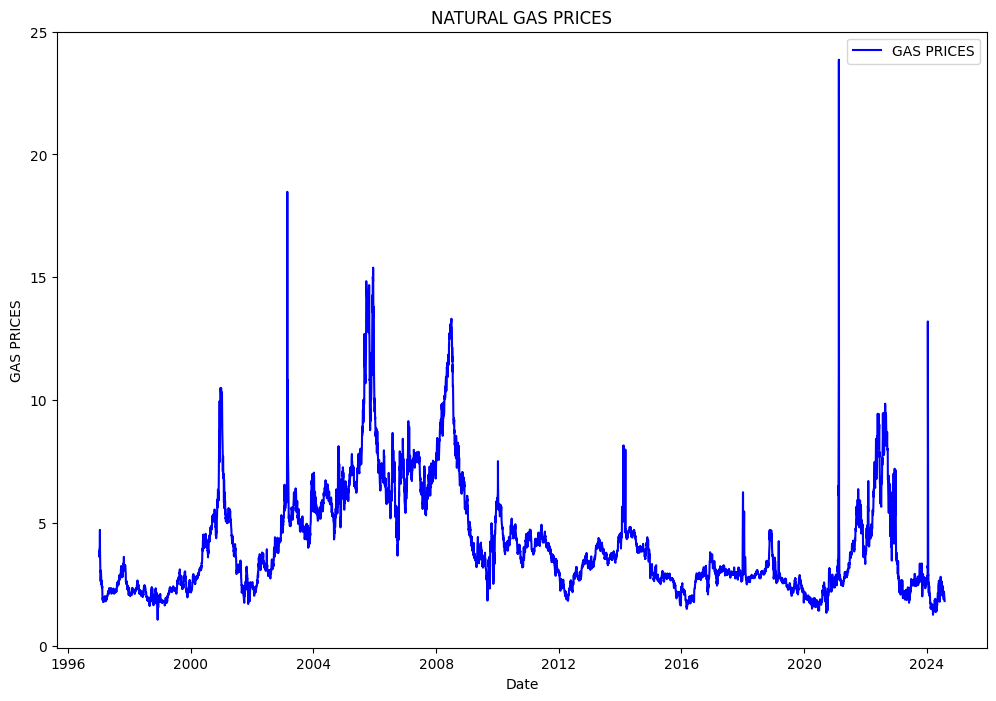

In [13]:
def plot_timeseries(final_d: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    plt.plot(final_d.index, final_d['price'], label="GAS PRICES", color="blue")
    plt.title("NATURAL GAS PRICES")
    plt.xlabel("Date")
    plt.ylabel("GAS PRICES")

    plt.legend()
    plt.show()
plot_timeseries(final_d)

Seasonal Decomposition using STL to decompose the time series into three main components:

**Trend:** Long-term movement in the data.

**Seasonality:** Repeating patterns after certain time interval.

**Residual (Noise):** Remaining component after removing trend and seasonality.

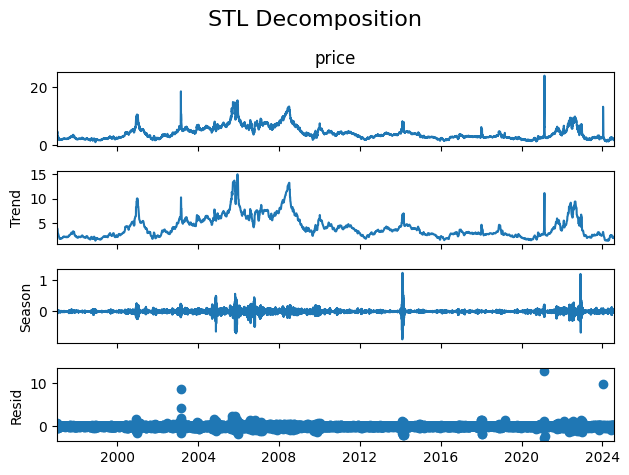

In [14]:
from statsmodels.tsa.seasonal import STL
stl = STL(final_d["price"], period=3, robust=True)
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
resid = result.resid

# Plot components
result.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

Many time It happens that we can not decompose how actually seasonality and trend exist into the data, even we are not able to say that trend is increasing or decreasing or seasonality is statistically significant or not. That's why We have used here two statistical test, where we are enable to say actual interior pattern.

**Mann–Kendall Test-** To test monotonic tren in the data.

**Friedman Test-** To test seasonality.

In [15]:
!pip install pymannkendall

In [16]:
import pymannkendall as mk

result = mk.original_test(final_d['price'])
print(result)

Mann_Kendall_Test(trend='decreasing', h=np.True_, p=np.float64(0.0), z=np.float64(-16.716001575369923), Tau=np.float64(-0.13390070425717704), s=np.float64(-3214820.0), var_s=np.float64(36986926646.666664), slope=np.float64(-0.00018267094544556893), intercept=np.float64(4.072863490496173))


If trend: increasing/decreasing → there is a trend.

If trend: no trend → stationary (no trend).

In [17]:
import pandas as pd
from scipy.stats import friedmanchisquare
# Extract month and year from datetime index
final_d['month'] = final_d.index.month
final_d['year'] = final_d.index.year
# Aggregate by year & month (average price per month)
monthly_avg = final_d.groupby(['year', 'month'])['price'].mean().reset_index()
# Pivot table: rows = year, columns = month
pivot = monthly_avg.pivot(index='year', columns='month', values='price')
# Drop incomplete years (those missing some months)
pivot = pivot.dropna()
monthly_groups = [pivot[col].values for col in pivot.columns]
stat, p = friedmanchisquare(*monthly_groups)
if p<0.05:
  print("Reject null hypotheis, H0= The distribution of natural gas prices is the same across all months, means no monthly seasonality")
else:
  print("Fail to reject null hypothesis, H0 =The distribution of natural gas prices is the same across all months, means no monthly seasonality")
print("Statistic:", stat)
print("p-value:", p)

Fail to reject null hypothesis, H0 =The distribution of natural gas prices is the same across all months, means no monthly seasonality
Statistic: 6.703147260717536
p-value: 0.8225885875250954


# ADF and KPSS test for Unit Root test .

In [18]:
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series, regression_adf='ct', regression_kpss='ct'):
    """
    Runs ADF and KPSS tests on a time series and provides robust interpretation.

    Parameters:
    series : pd.Series
        Time series data.
    regression_adf : str
        'c' for constant, 'ct' for constant + trend in ADF.
    regression_kpss : str
        'c' for level stationary, 'ct' for trend stationary in KPSS.
    """
    series = series.dropna()  # remove missing values

    print("=== Augmented Dickey-Fuller (ADF) Test ===")
    adf_result = adfuller(series, maxlag=None, regression=regression_adf, autolag='AIC')
    adf_stat, adf_p, adf_lag, adf_nobs, adf_crit = adf_result[:5]

    print(f"ADF Statistic: {adf_stat}")
    print(f"p-value: {adf_p}")
    print(f"Used Lag: {adf_lag}")
    print(f"Number of Observations: {adf_nobs}")
    print(f"Critical Values: {adf_crit}")

    adf_stationary = adf_p < 0.05
    print("Interpretation: " + ("Stationary (reject H0)" if adf_stationary else "Non-stationary (fail to reject H0)"))
    print()

    print("=== KPSS Test ===")
    try:
        kpss_result = kpss(series, regression=regression_kpss, nlags='auto')
        kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss_result[:4]

        print(f"KPSS Statistic: {kpss_stat}")
        print(f"p-value: {kpss_p}")
        print(f"Lags Used: {kpss_lags}")
        print(f"Critical Values: {kpss_crit}")

        kpss_stationary = kpss_p >= 0.05
        print("Interpretation: " + ("Stationary (fail to reject H0)" if kpss_stationary else "Non-stationary (reject H0)"))
    except ValueError as e:
        print("KPSS test could not be run:", e)

    # ✅ Combined professional conclusion
    print("\n=== Combined Conclusion ===")
    if adf_stationary and kpss_stationary:
        print("Series is stationary (strong evidence).")
    elif not adf_stationary and not kpss_stationary:
        print("Series is non-stationary (strong evidence). Consider differencing.")
    else:
        print("Series may be trend-stationary. Consider detrending or first-differencing.")

In [19]:
check_stationarity(final_d['price'],regression_adf='ct', regression_kpss='ct')

=== Augmented Dickey-Fuller (ADF) Test ===
ADF Statistic: -4.2493575206777905
p-value: 0.0037663091784820735
Used Lag: 7
Number of Observations: 6922
Critical Values: {'1%': np.float64(-3.9600784671634535), '5%': np.float64(-3.4111244562770944), '10%': np.float64(-3.127423615645729)}
Interpretation: Stationary (reject H0)

=== KPSS Test ===
KPSS Statistic: 1.1038681772411625
p-value: 0.01
Lags Used: 52
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Interpretation: Non-stationary (reject H0)

=== Combined Conclusion ===
Series may be trend-stationary. Consider detrending or first-differencing.


/tmp/ipython-input-1269610805.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression=regression_kpss, nlags='auto')


So, Our univariate variable is non stationary.Now, we have to make it stationary by having first difference.

In [20]:
final_d["price_diff"]=final_d["price"].diff()
final_d=final_d.dropna()

In [21]:
final_d

,price,month,year,price_diff
DATE,,,,
1997-01-08,3.80,1,1997,-0.02
1997-01-09,3.61,1,1997,-0.19
1997-01-10,3.92,1,1997,0.31
1997-01-13,4.00,1,1997,0.08
1997-01-14,4.01,1,1997,0.01
...,...,...,...,...
2024-07-24,2.00,7,2024,-0.13
2024-07-25,2.00,7,2024,0.00
2024-07-26,1.98,7,2024,-0.02


**Again we have checked for stationarity after having first difference.**

In [22]:
check_stationarity(final_d['price_diff'],regression_adf='ct', regression_kpss='ct')

=== Augmented Dickey-Fuller (ADF) Test ===
ADF Statistic: -39.7913948899233
p-value: 0.0
Used Lag: 6
Number of Observations: 6922
Critical Values: {'1%': np.float64(-3.9600784671634535), '5%': np.float64(-3.4111244562770944), '10%': np.float64(-3.127423615645729)}
Interpretation: Stationary (reject H0)

=== KPSS Test ===
KPSS Statistic: 0.01803853946739074
p-value: 0.1
Lags Used: 80
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Interpretation: Stationary (fail to reject H0)

=== Combined Conclusion ===
Series is stationary (strong evidence).


/tmp/ipython-input-1269610805.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression=regression_kpss, nlags='auto')


**We can get visual understanding by calculating rolling mean, rolling standard deviation for new values of price differenciation.**

In [23]:
def plot_roll_mean_std(df,col):

    rolling_std =df[col].rolling(window=12).std()
    rolling_mean =df[col].rolling(window=12).mean()
    plt.plot(df[col], label='Original')
    plt.plot(rolling_std, label='Rolling Std', color='red')
    plt.plot(rolling_mean, label='Rolling mean', color='green')
    plt.legend()
    plt.title("Rolling Standard Deviation")
    plt.show()

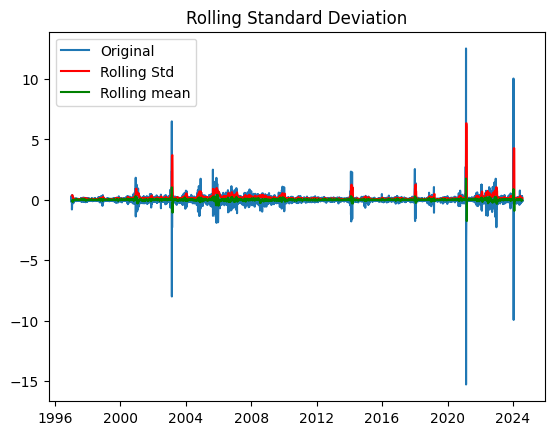

In [ ]:
plot_roll_mean_std(final_d,'price_diff')

## **I am going to use ensembling tenchnique by providing some advance statistical models. Where we can make a good idea actualy how much efficiency and accuray can increase after using ensembling technique**.

In [24]:
cols_to_drop = ['year', 'month', 'price_diff'] # I want to remove two columns
final_d = final_d.drop(columns=[col for col in cols_to_drop if col in final_d.columns])

In [25]:
final_d.head()

,price
DATE,
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00
1997-01-14,4.01


In [26]:
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, AutoTheta
from utilsforecast.evaluation import evaluate
import utilsforecast.losses as L

In [29]:
print(type(final_d))

<class 'pandas.core.frame.DataFrame'>


In [28]:
df_sf = final_d.reset_index().rename(columns={'DATE': 'ds', 'price': 'y'})
df_sf['unique_id'] = 'series_1'
df_sf = df_sf[['unique_id', 'ds', 'y']].dropna().sort_values('ds')

In [30]:
df_sf

,unique_id,ds,y
0,series_1,1997-01-08,3.80
1,series_1,1997-01-09,3.61
2,series_1,1997-01-10,3.92
3,series_1,1997-01-13,4.00
4,series_1,1997-01-14,4.01
...,...,...,...
6924,series_1,2024-07-24,2.00
6925,series_1,2024-07-25,2.00
6926,series_1,2024-07-26,1.98
6927,series_1,2024-07-29,1.90


In [31]:
# 1) Infer frequency
freq = pd.infer_freq(df_sf['ds'])
if freq is None:
    freq = 'MS'  # fallback for monthly data

# 2) Map frequency to seasonal length
sp_map = {'MS': 12, 'M': 12, 'W': 52, 'D': 7, 'H': 24}  # adjust as needed
sp = sp_map.get(freq, 12)  # default 12 if unknown

In [32]:
sp

12

In [33]:
# Train and test spliting procedure
h = 24
train = df_sf.iloc[:-h].copy()
test  = df_sf.iloc[-h:].copy()

In [34]:
print("Train size:", len(train))
print("Test size:", len(test))
print("Train ends at:", train['ds'].iloc[-1])
print("Test starts at:", test['ds'].iloc[0])

Train size: 6905
Test size: 24
Train ends at: 2024-06-25 00:00:00
Test starts at: 2024-06-26 00:00:00


In [35]:
models = [
    AutoARIMA(season_length=sp, alias='AutoARIMA'),
    AutoETS(season_length=sp, model='ZZZ', alias='AutoETS'),
    AutoCES(season_length=sp, alias='AutoCES'),
    AutoTheta(season_length=sp, alias='AutoTheta'),
]

In [36]:
# 6) Initialize forecaster
sf = StatsForecast(models=models, freq=freq, n_jobs=-1)

In [37]:
# 7) Fit on TRAIN
sf.fit(train)

StatsForecast(models=[AutoARIMA,AutoETS,AutoCES,AutoTheta])

In [38]:
# 8) Forecast TEST set
test_fcst = sf.predict(h=len(test))
test_fcst = test_fcst.merge(test[['unique_id','ds','y']], on=['unique_id','ds'], how='left')

In [39]:
test_fcst

,unique_id,ds,AutoARIMA,AutoETS,AutoCES,AutoTheta,y
0,series_1,2024-07-01,2.582547,2.611355,2.577286,2.592069,2.21
1,series_1,2024-08-01,2.574874,2.612712,2.566519,2.596111,NaN
2,series_1,2024-09-01,2.568953,2.613798,2.552609,2.602934,NaN
3,series_1,2024-10-01,2.562541,2.614667,2.541240,2.600900,NaN
4,series_1,2024-11-01,2.560539,2.615362,2.528012,2.606489,NaN
5,series_1,2024-12-01,2.560026,2.615918,2.516331,2.599263,NaN
6,series_1,2025-01-01,2.559700,2.616363,2.503559,2.607249,NaN
7,series_1,2025-02-01,2.559742,2.616719,2.491738,2.602566,NaN
8,series_1,2025-03-01,2.559859,2.617004,2.479287,2.606927,NaN
9,series_1,2025-04-01,2.559914,2.617232,2.467428,2.603213,NaN


In [40]:
# 9) Manual Ensemble: average across all models
model_cols = [m.alias for m in models]  # use aliases instead of class names
test_fcst['yhat'] = test_fcst[model_cols].mean(axis=1)

In [41]:
test_fcst.head()

,unique_id,ds,AutoARIMA,AutoETS,AutoCES,AutoTheta,y,yhat
0,series_1,2024-07-01,2.582547,2.611355,2.577286,2.592069,2.21,2.590814
1,series_1,2024-08-01,2.574874,2.612712,2.566519,2.596111,NaN,2.587554
2,series_1,2024-09-01,2.568953,2.613798,2.552609,2.602934,NaN,2.584574
3,series_1,2024-10-01,2.562541,2.614667,2.541240,2.600900,NaN,2.579837
4,series_1,2024-11-01,2.560539,2.615362,2.528012,2.606489,NaN,2.577601


In [42]:
from functools import partial
# Define metrics with seasonality for MASE
metrics = [
    L.mae,
    L.rmse,
    L.mape,
    L.smape,
    partial(L.mase, seasonality=12)
]
# --- 10) Evaluate holdout (TEST set) ---
test_scores = evaluate(test_fcst, metrics=metrics, train_df=train)
print("\nHoldout metrics for manual Ensemble:")
print(test_scores)


Holdout metrics for manual Ensemble:
  unique_id metric  AutoARIMA   AutoETS   AutoCES  AutoTheta      yhat
0  series_1    mae   0.372547  0.401355  0.367286   0.382069  0.380814
1  series_1   rmse   0.372547  0.401355  0.367286   0.382069  0.380814
2  series_1   mape   0.168573  0.181608  0.166193   0.172882  0.172314
3  series_1  smape   0.003239  0.003469  0.003197   0.003315  0.003305
4  series_1   mase   0.818770  0.882083  0.807208   0.839696  0.836940


In [43]:
# 1) Ensure train target is numeric
train['y'] = pd.to_numeric(train['y'], errors='coerce')

# 2) Run cross-validation
cv_df = sf.cross_validation(df=train, h=h, step_size=h, n_windows=3)

# 3) Ensure cv_df target is numeric
cv_df['y'] = pd.to_numeric(cv_df['y'], errors='coerce')

# 4) Drop datetime cols before evaluate
cv_eval = cv_df.drop(columns=['ds', 'cutoff'])

# 5) Evaluate CV metrics
cv_metrics = evaluate(cv_eval, metrics=metrics, train_df=train)
print(cv_metrics.head())

  unique_id metric  AutoARIMA   AutoETS   AutoCES  AutoTheta
0  series_1    mae   0.252983  0.309640  0.354035   0.283881
1  series_1   rmse   0.348657  0.399013  0.448920   0.379958
2  series_1   mape   0.124145  0.161065  0.178431   0.143930
3  series_1  smape   0.068076  0.089280  0.101391   0.079179
4  series_1   mase   0.555996  0.680514  0.778085   0.623903


In [44]:
cv_metrics

,unique_id,metric,AutoARIMA,AutoETS,AutoCES,AutoTheta
0,series_1,mae,0.252983,0.309640,0.354035,0.283881
1,series_1,rmse,0.348657,0.399013,0.448920,0.379958
2,series_1,mape,0.124145,0.161065,0.178431,0.143930
3,series_1,smape,0.068076,0.089280,0.101391,0.079179
4,series_1,mase,0.555996,0.680514,0.778085,0.623903


In [45]:
# --- 11) Refit on FULL data and forecast future ---
sf.fit(df_sf)
future_h = 24
future_fcst = sf.predict(h=future_h)

In [46]:
# Manual Ensemble for future
model_aliases = [m.alias for m in models]
future_fcst['yhat'] = future_fcst[model_aliases].mean(axis=1)

In [47]:
future_fcst

,unique_id,ds,AutoARIMA,AutoETS,AutoCES,AutoTheta,yhat
0,series_1,2024-08-01,1.855352,1.806806,1.823714,1.831945,1.829454
1,series_1,2024-09-01,1.882640,1.803604,1.814440,1.834916,1.833900
2,series_1,2024-10-01,1.888441,1.800900,1.805876,1.839383,1.833650
3,series_1,2024-11-01,1.897545,1.798618,1.796840,1.837714,1.832679
4,series_1,2024-12-01,1.901794,1.796691,1.788245,1.841295,1.832006
5,series_1,2025-01-01,1.902150,1.795064,1.779385,1.836692,1.828323
6,series_1,2025-02-01,1.902404,1.793691,1.770806,1.841965,1.827217
7,series_1,2025-03-01,1.902399,1.792532,1.762085,1.838724,1.823935
8,series_1,2025-04-01,1.902175,1.791553,1.753549,1.842265,1.822385
9,series_1,2025-05-01,1.902061,1.790727,1.744943,1.839748,1.819370


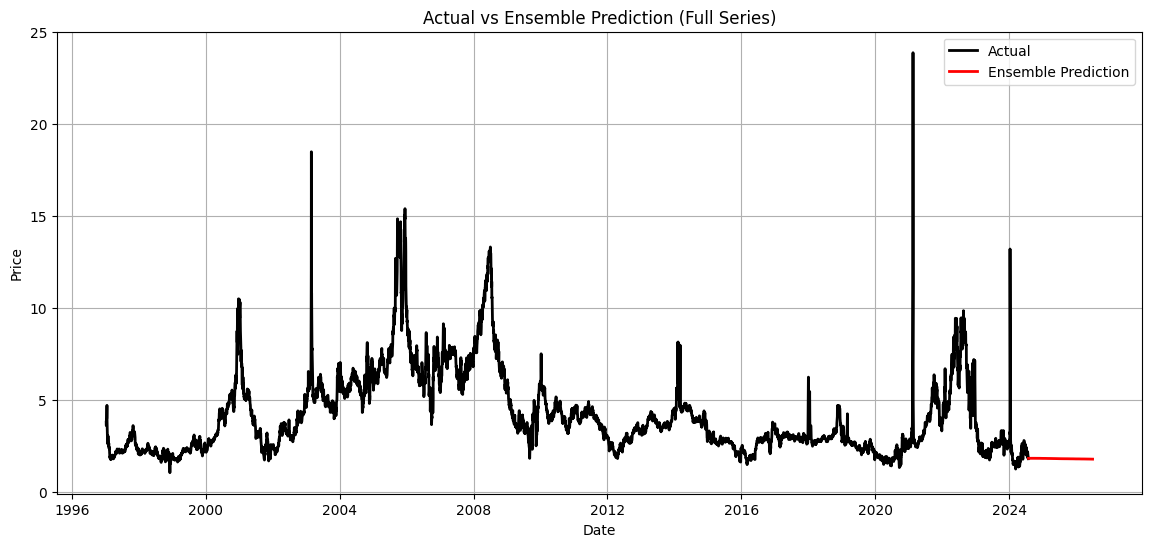

In [48]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(df_sf['ds'], df_sf['y'], label='Actual', color='black', linewidth=2)
plt.plot(future_fcst['ds'], future_fcst['yhat'], label='Ensemble Prediction', color='red', linewidth=2)
plt.title('Actual vs Ensemble Prediction (Full Series)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Evaluate future forecasts (since no actuals yet, we just show predictions)
print("\nNext {}-step forecast with manual Ensemble:".format(future_h))
print(future_fcst[['unique_id', 'ds', 'yhat']])


Next 24-step forecast with manual Ensemble:
   unique_id         ds      yhat
0   series_1 2024-08-01  1.829454
1   series_1 2024-09-01  1.833900
2   series_1 2024-10-01  1.833650
3   series_1 2024-11-01  1.832679
4   series_1 2024-12-01  1.832006
5   series_1 2025-01-01  1.828323
6   series_1 2025-02-01  1.827217
7   series_1 2025-03-01  1.823935
8   series_1 2025-04-01  1.822385
9   series_1 2025-05-01  1.819370
10  series_1 2025-06-01  1.816670
11  series_1 2025-07-01  1.812880
12  series_1 2025-08-01  1.810320
13  series_1 2025-09-01  1.808855
14  series_1 2025-10-01  1.807798
15  series_1 2025-11-01  1.805227
16  series_1 2025-12-01  1.803994
17  series_1 2026-01-01  1.800732
18  series_1 2026-02-01  1.799958
19  series_1 2026-03-01  1.797073
20  series_1 2026-04-01  1.795899
21  series_1 2026-05-01  1.793225
22  series_1 2026-06-01  1.790802
23  series_1 2026-07-01  1.787278
